<h2><font color="#004D7F" size=5>Módulo 2: Bootstrap Aggregation</font></h2>



<h1><font color="#004D7F" size=6> 4. Feature Selection Subspace </font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Aprendizaje Automático II</font><br>
<font color="#004D7F" size=3>Universidad Nacional de Educación a Distancia</font>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>


* [1. Algoritmo de conjunto Feature Selection Subspace](#section1)
* [2. Feature Selection Subspace: Método simple](#section2)
    * [2.1. Estadístico ANOVA](#section21)
    * [2.2. Información Mutua](#section22)
    * [2.3. Selección de Características Recursivas (RFE)](#section23)
* [3. Combined Feature Selection](#section3)
   * [3.1. Conjunto con número fijo de características](#section31)
   * [3.2. Conjunto con número continuo de características](#section32)
* [Ejercicios](#sectionEj)

---

<a id="section0"></a>
# <font color="#004D7F">0. Contexto</font>

- Random Subspace consiste en el ajuste del modelo en diferentes grupos de características de entrada (columnas) seleccionados aleatoriamente en train. 
- Feature selection son las técnicas más populares. 

Después de completar este tutorial, sabrá:
- La selección de características proporciona una alternativa a Random Subspace para seleccionar grupos de entradas decaracterísticas.
- Cómo desarrollar y evaluar conjuntos mediante técnicas de selección de elementos individuales.
- Cómo desarrollar y evaluar conjuntos seleccionadas mediante múltiples técnicas diferentes de selección de características.

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section1"></a>
# <font color="#004D7F"> 1. Algoritmo de conjunto Feature Selection Subspace</font>

- Random Subspace ajusta un modelo en diferentes grupos de columnas seleccionadas al azar en el conjunto de datos de entrenamiento. 
- La diferencia en la elección de las columnas de cada modelo del conjunto da como resultado una diversidad de modelos y sus predicciones. 
- Cada modelo funciona bien, aunque cada uno lo hace de manera diferente, cometiendo diferentes errores.
- La selección de características intenta seleccionar un subconjunto de columnas que sea más relevante para la variable de destino. 
- Los enfoques populares implican el uso:
    - De medidas estadísticas, como información mutua, y
    - La evaluación de modelos en subconjuntos de características y la selección del subconjunto que da como resultado el modelo de mejor rendimiento, lo que se denomina eliminación recursiva de características (RFE) para abreviar.
- La diferencia principal con Random Subspaces es que este selecciona características al azar
- Feautre Selection Subspaces lo hace en base a un método de Feature Selection, i.e., en base a una métrica.

Dos enfoques naturales incluyan:
- __Método simple__: genera un subespacio de características para cada número de características desde 1 hasta el número de columnas, ajusta un modelo en cada una y combina sus predicciones.
- __Múltiples métodos__: genere un subespacio de características usando múltiples métodos de selección de características diferentes, ajusta un modelo a cada uno y combinar sus predicciones.

<figure><center>
  <img src="data/featureSelectionSubset.png" width="450" height="450" alt="Gráfica">
  <figcaption><blockquote>feature Selection Subset. Extraída de <a href="http://dx.doi.org/10.21203/rs.3.rs-3229911/v1">Random Subspace Evolutionary Feature Selection for High-dimensional Data</a></blockquote></figcaption>
</center></figure>

<a id="section11"></a> 
## <font color="#004D7F"> 1.1. Dataset</font>

Definamos un problema de prueba como base para esta exploración y establezcamos una línea de base en el rendimiento para ver si ofrece un beneficio sobre un solo modelo. Primero, podemos usar la función `make_classification()` para crear un problema de clasificación binaria sintética con 1000 ejemplos y 20 características de entrada. El ejemplo completo se enumera a continuación.

In [10]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=5)
print(X.shape, y.shape)

(1000, 20) (1000,)


La ejecución del ejemplo crea el conjunto de datos y resume la forma de los componentes de entrada y salida.

<a id="section12"></a> 
## <font color="#004D7F"> 1.2. Resultado de línea base</font>

Establecemos una línea de base en el desempeño. Usaremos árboles de decisión.

In [11]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# Definimos el modelo de línea base
model = DecisionTreeClassifier()
# método de evaulación
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluamos
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# reportamos el rendimiento
print('Accuracy medio: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy medio: 0.796 (0.050)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section2"></a> 
# <font color="#004D7F"> 2. Feature Selection Subspace: Método simple</font>

Veamos la creación de un conjunto a partir de las funciones seleccionadas mediante el método Feature Selection Subspace individual. 
- Para un método de selección de características determinado, lo aplicaremos repetidamente con diferentes números de características seleccionadas para crear __múltiples subespacios de características__. 
- Luego entrenaremos __un modelo en cada uno__, en este caso, un árbol de decisión, y combinaremos las predicciones. 
- Hay muchas formas de combinar las predicciones,en este caso usaremos un conjunto de votación que se puede configurar para usar votación dura (en este caso) o blanda para la clasificación, o promediando para la regresión.

El procedimiento será el siguiente:
1. Cada modelo en el conjunto de votación será un `Pipeline` donde el primer paso es un método de selección de características, configurado para seleccionar una cantidad específica de características, seguido de un modelo clasificador de árbol de decisión. 
2. Crearemos un subespacio de selección de características para cada número de columnas en el conjunto de datos de entrada, desde 1 hasta el número de columnas. 
3. Definimos una función auxiliar llamada `get_ensemble()` que crea un conjunto de votación (`VotingClassifier`) con miembros basados en selección de características para un número determinado de características de entrada.
    - Podemos utilizar otros métodos de selección de características diferentes al del ejemplo
5. Se utiliza el sistema de votos mayoritarios de las predicciones realizadas por los miembros contribuyentes.

Dado que estamos trabajando con un conjunto de datos de clasificación, exploraremos tres métodos de selección características diferentes:
- Estadístico ANOVA.
- Información mutua.
- Selección de funciones recursivas (RFE).

<a id="section21"></a> 
## <font color="#004D7F"> 2.1. Estadístico ANOVA</font>

- Un test F, es una clase de pruebas estadísticas que calculan la relación entre valores de varianzas, como la varianza de dos muestras diferentes o la varianza explicada y no explicada mediante una prueba estadística, como ANOVA. 
- ANOVA es una prueba de hipótesis estadística paramétrica para determinar si las medias de dos o más muestras de datos (a menudo tres o más) provienen de la misma distribución o no. 
- La librería scikit-learn proporciona una implementación del ANOVA en la función `f_classif()` a través de la clase `SelectKBest`.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la clase [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la función [`f_classif()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif)
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la clase [`VotingClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
</div>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la clase [`Pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
</div>

In [14]:
def get_ensemble(n_features):
    # definimos los modelos de línea base
    models = list()
    # enumeramos las características en train
    for i in range(1, n_features+1):
        # creamos el método de feature selection
        fs = SelectKBest(score_func=f_classif, k=i)
        # creamos el modelo
        model = DecisionTreeClassifier()
        # creamos un pipeline
        pipeline = Pipeline([('fs',fs), ('m', model)])
        # añadimos la tupa en la lista de modelos para voting
        models.append((str(i), pipeline))
    # definimos el modelo Voting
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

In [15]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=5)
# obtenemos los modelos de conjunto y le pasamos el número de características
ensemble = get_ensemble(X.shape[1])
# evaluamos el modelo
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy medio: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy medio: 0.830 (0.046)


La ejecución del ejemplo informa el accuracy de la media y la desviación estándar del modelo.

En este caso, podemos ver un aumento en el rendimiento con respecto a un solo modelo que logró un accuracy de aproximadamente 79,4% a aproximadamente 83,2% utilizando un conjunto de modelos sobre características seleccionadas por la estadística ANOVA.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section22"></a> 
## <font color="#004D7F"> 2.2. Información Mutua</font>

- La información mutua del campo de la teoría de la información es la aplicación de la ganancia de información (normalmente utilizada en la construcción de árboles de decisión) a la selección de características. 
- La información mutua se calcula entre dos variables y mide la reducción de la incertidumbre de una variable dado un valor conocido de la otra variable. 
- Scikit-learn proporciona una implementación de información mutua para la selección de características a través de la función `mutual_info_classif()` en la clase `SelectKBest`.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la función [`mutual_info_classif()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)
</div>

In [16]:
from sklearn.feature_selection import mutual_info_classif

def get_ensemble(n_features):
    models = list()
    for i in range(1, n_features+1):
        # creamos el método de feature selection
        fs = SelectKBest(score_func=mutual_info_classif, k=i)
        # creamos el modelo
        model = DecisionTreeClassifier()
        pipe = Pipeline([('fs', fs), ('m', model)])
        models.append((str(i),pipe))
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

In [17]:
ensemble = get_ensemble(X.shape[1])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy medio: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy medio: 0.830 (0.042)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section23"></a> 
## <font color="#004D7F"> 2.3. Selección de Características Recursivas (RFE)</font>

- La eliminación recursiva de funciones (RFE) busca un subconjunto de funciones comenzando con todas las funciones en el conjunto de datos de entrenamiento y eliminando funciones exitosamente hasta que quede el número deseado. 
- RFE está disponible a través de la clase `RFE` en Scikit-learn.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Más información sobre la clase [`RFE`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)
</div>

In [18]:
from sklearn.feature_selection import RFE

def get_ensemble(n_features):
    models = list()
    for i in range(1, n_features+1):
        # creamos el método de feature selection
        fs = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
        # creamos el modelo
        model = DecisionTreeClassifier()
        pipe = Pipeline([('fs', fs), ('m', model)])
        models.append((str(i),pipe))
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

In [19]:
ensemble = get_ensemble(X.shape[1])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy medio: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy medio: 0.827 (0.042)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section3"></a> 
# <font color="#004D7F"> 3. Combined Feature Selection</font>

- Hasta ahora hemos visto un solo modelo utilizando un método de selección de características únicas como base de una predicción conjunta para un conjunto de datos. 
- Esperaríamos que las predicciones entre muchos de los miembros del conjunto estuvieran correlacionadas. 
- Esto podría solucionarse utilizando diferentes números de características en lugar de un número contiguo de características de 1 al número de columnas. 

Un enfoque alternativo para introducir diversidad es seleccionar subespacios de características utilizando diferentes métodos de selección de características. Exploraremos dos versiones de este enfoque. 
1. Con el primero, seleccionaremos la misma cantidad de características de cada método, y 
2. Con el segundo, seleccionaremos una cantidad contigua de características de 1 a la cantidad de columnas para múltiples métodos.

<a id="section31"></a> 
## <font color="#004D7F"> 3.1. Conjunto con número fijo de características</font>

1. Seleccionaremos una cantidad arbitraria de características.
2. Usaremos cada uno de los tres métodos de selección de características para seleccionar un subespacio de características.
3. Ajustaremos un modelo de cada uno y los usaremos como base para un conjunto de votación. Implemetaresmos la función `get_ensemble()`.
4. Esperamos que las características seleccionadas por cada método sean lo suficientemente diferentes para dar como resultado un conjunto eficaz.

In [20]:
def get_ensemble(n_features):
    models = list()
    # miembros ANOVA
    fs = SelectKBest(score_func=f_classif, k=n_features)
    anova = Pipeline([('fs', fs), ('m', DecisionTreeClassifier())])
    models.append(('anova', anova))
    # Información mútua
    fs = SelectKBest(score_func=mutual_info_classif, k=n_features)
    mutual = Pipeline([('fs', fs), ('m', DecisionTreeClassifier())])
    models.append(('mutual', mutual))
    # RFE
    fs = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features)
    rfe = Pipeline([('fs', fs), ('m', DecisionTreeClassifier())])
    models.append(('rfe', rfe))
    # definimos Votingdefine the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

In [21]:

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)

ensemble = get_ensemble(12)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy medio: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy medio: 0.838 (0.039)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section311"></a> 
### <font color="#004D7F"> 3.1.1. Comparación con cada modelo individualmente</font>

Una comparación más justa podría ser comparar este resultado con cada modelo individual que comprende el conjunto. 

In [22]:
from matplotlib import pyplot

def get_ensemble(n_features):
    models, names = list(), list()
    # ANOVA
    fs = SelectKBest(score_func=f_classif, k=n_features)
    anova = Pipeline([('fs', fs), ('m', DecisionTreeClassifier())])
    models.append(('anova', anova))
    names.append('anova')
    # Información mutua
    fs = SelectKBest(score_func=mutual_info_classif, k=n_features)
    mutinfo = Pipeline([('fs', fs), ('m', DecisionTreeClassifier())])
    models.append(('mutinfo', mutinfo))
    names.append('mutinfo')
    # RFE
    fs = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features)
    rfe = Pipeline([('fs', fs), ('m', DecisionTreeClassifier())])
    models.append(('rfe', rfe))
    names.append('rfe')
    ensemble = VotingClassifier(estimators=models, voting='hard')
    names.append('ensemble')
    return names, [anova, mutinfo, rfe, ensemble]

In [23]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)

names, models = get_ensemble(15)
# evaluar cada modelo
results = list()
for model, name in zip(models, names):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    #Almacenar resultados
    results.append(n_scores)
    print('>%s: %.3f (%.3f)' % (name, mean(n_scores), std(n_scores)))

>anova: 0.817 (0.039)
>mutinfo: 0.809 (0.040)
>rfe: 0.829 (0.038)
>ensemble: 0.841 (0.039)


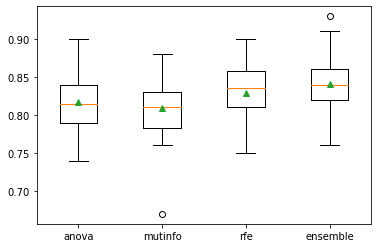

In [24]:
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

<a id="section32"></a> 
## <font color="#004D7F"> 3.2. Conjunto con número continuo de características</font>

En este caso seleccionaremos subespacios como hicimos en la sección anterior desde 1 hasta el número de columnas del conjunto de datos, aunque en este caso repetiremos el proceso con cada método de selección de características.

Esperamos que la diversidad de las características seleccionadas a través de los métodos de selección de características resulte en un aumento adicional en el rendimiento del conjunto.

In [27]:
def get_ensemble(n_features_start, n_features_end):
    models = list()
    for i in range(n_features_start, n_features_end+1):
        # anova 
        fs = SelectKBest(score_func=f_classif, k=i)
        anova = Pipeline([('fs', fs), ('m', DecisionTreeClassifier())])
        models.append(('anova'+str(i), anova))
        # mutual information 
        fs = SelectKBest(score_func=mutual_info_classif, k=i)
        mutinfo = Pipeline([('fs', fs), ('m', DecisionTreeClassifier())])
        models.append(('mutinfo'+str(i), mutinfo))
        # RFE
        fs = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
        rfe = Pipeline([('fs', fs), ('m', DecisionTreeClassifier())])
        models.append(('rfe'+str(i), rfe))
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

In [30]:
get_ensemble(4, 16)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy medio: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy medio: 0.840 (0.039)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> __Nota__: Sus resultados pueden variar dada la naturaleza estocástica del algoritmo o procedimiento de evaluación, o diferencias en la precisión numérica. Considere ejecutar el ejemplo varias veces y comparar el resultado promedio.
</div>

---
<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="sectionEj"></a>
<h3><font color="#004D7F" size=6> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i> Ejercicios</font></h3>

Se proponen las siguientes actividades para consolidar el aprendizaje.

# <font color="#004D7F" size=5>Ejercicio 1</font>
__Hiperparámtros__. Explore diferentes configuraciones para la cantidad de árboles e incluso configuraciones de árbol individuales para ver si puede mejorar aún más los resultados. 

# <font color="#004D7F" size=5>Ejercicio 2</font>
__Problema de Regresión__. Esté tipo de métodos se puede utilizar con árboles de regresión, desarrolle este concepto.

# <font color="#004D7F" size=5>Ejercicio 3</font>
__Datasets reales__. Busque un dataset original y verdadero (que no sea sintético) y evalúe el uso de los conceptos vistos en esta unidad. Los conjuntos de datos en pueden ser obtenidos del [repositorio de aprendizaje automático de UCI](https://archive.ics.uci.edu/).

# <font color="#004D7F" size=5>Ejercicio 4</font>
__Feature Selection__. En este ejemplo hemos desarrollado estos conceptos con 3 métodos de selección de características. Existen muchos más, busque información sobre ellos y evalúe la opción de utilizar otros en un ejemplo como el realizado en esta unidad.

# <font color="#004D7F" size=5>Ejercicio 5</font>
__Método múltiple__. En este ejemplo hemos desarrollado resolver este problema con el método simple. Existe el método múltiple, busque información sobre ello y evalúe la opción de utilizarlo en un ejemplo como el realizado en esta unidad.

# <font color="#004D7F" size=5>Ejercicio 6</font>
__Métodos de Feature selection__. En el punto 2 se ha utilizado la clase `SelectKBest`. Evalúe 3 métodos diferentes y compruebe quién tiene mejor comportamiento

# <font color="#004D7F" size=5>Ejercicio 7</font>
__Búsqueda de la mejor configuración__. Como se ha visto existen diferentes hiperparámetros que pueden ajustar nuestro modelo. Haga una búsqueda para un dataset real de cuales, entre un rango amplio de hiperparétros, maximizan la métrica. Puede utilizar una búsqueda aleatoria.

---

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>